In [ ]:
# converts txt to csv files
import csv 

def txt_to_csv(txt_file):
    csv_file = txt_file.split('/')[-1].split('.')[0] + '.csv'
    csv_file = '/'.join(txt_file.split('/')[:-1]) + '/' + csv_file
    
    inp_data = list()
    with open(txt_file, 'r') as in_file:
        stripped = (line.strip() for line in in_file)
        inp_data = [line.split("\t") for line in stripped if line]
    
    # creating dataframe
    df = pd.DataFrame(inp_data[1:-2], columns=inp_data[0])
    print(df.head())
    df.to_csv(csv_file)

In [1]:
# Loading data
import pandas as pd
crime_data = pd.read_csv("../../../../Downloads/Crimes_-_2001_to_present.csv")

In [12]:
data = list(crime_data['Case Number'])

import json
with open('document_id.json', 'w') as f:
    json.dump(data, f)
    

In [13]:
with open('document_id.json') as json_file:
    data = json.load(json_file)

print (len(data))

6976448


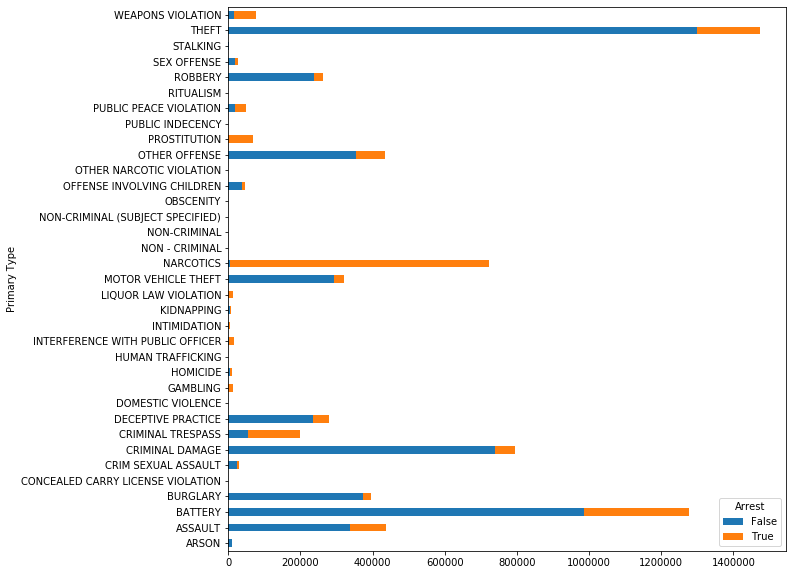

In [17]:
# Analysis harness
import pandas as pd

# To show different metrics
# analysis_df.info()
# analysis_df['Arrest'].describe()

import numpy as np
from matplotlib import cm
color = cm.inferno_r(np.linspace(.4,.8, 30))

analysis_df.groupby(['Primary Type', 'Arrest']).size().unstack().plot(kind='barh', stacked=True, figsize=(10,10))
# df2 = analysis_df.groupby(['Primary Type', 'Arrest'])['Primary Type'].count().unstack('Arrest').fillna(0)
# print (df2.head())
# df2[[False,True]].plot(kind='bar', stacked=True)

# analysis_df['Primary Type'].value_counts().plot(kind='barh', figsize=(10,10), color=color)
# analysis_df.isnull().sum().plot(kind='barh', figsize=(10,10), color=color)
# analysis_df[analysis_df['Arrest']==False]['Primary Type'].value_counts().plot(kind='pie', figsize=(10,10))
# df = analysis_df[analysis_df['Arrest']==False]['Primary Type'].value_counts()
# python_pie3D(df.data, df.index)

# To get null values
# analysis_df.isnull().sum()

# Finding co-relation
# correlation_matrix = analysis_df.corr().round(2)
# sns.heatmap(data=correlation_matrix, annot=True)

In [5]:
# REST API Client
import requests

class API_client:
    def __init__(self, url, username, password):
        self._url = url
        self._auth = (username, password)
        
    def set_url(self, url):
        '''
        to reset url
        '''
        self._url = url
        
    def get_response(self):
        '''
        get response from url
        '''
        resp = requests.get(self._url, auth=self._auth)
        
        if resp.status_code != 200:
            # This means something went wrong.
            raise ApiError('GET rest API issue: {}'.format(resp.status_code))
            
        return resp.json()
    
    def put_response(self, data):
        '''
        put response
        '''
        resp = requests.post(self._url, auth=self._auth, json=data)
        
        if resp.status_code != 201:
            raise ApiError('POST rest API issue: {}'.format(resp.status_code))
            
        return 'POST successful'
        
    def __str__(self):
        return 'This is a REST API functions wrapper'

In [ ]:
# analysis_df = analysis_df.to_json(orient='index')
host_name = 'http://localhost:8091'
rest_client = API_client(couchbase_url, 'administrator', 'nainyjain')

# Exploration
url_1 = '/pools/default/buckets'

rest_client.set_url(host_name+url_1)
print (rest_client.get_response())

In [14]:
crime_data.columns

Index(['ID', 'Case Number', 'Date', 'Block', 'IUCR', 'Primary Type',
       'Description', 'Location Description', 'Arrest', 'Domestic', 'Beat',
       'District', 'Ward', 'Community Area', 'FBI Code', 'X Coordinate',
       'Y Coordinate', 'Year', 'Updated On', 'Latitude', 'Longitude',
       'Location', 'Historical Wards 2003-2015', 'Zip Codes',
       'Community Areas', 'Census Tracts', 'Wards', 'Boundaries - ZIP Codes',
       'Police Districts', 'Police Beats'],
      dtype='object')

In [2]:
# Data Ingestion

# Global connection objects
import json
import datetime
from couchbase.cluster import Cluster
from couchbase.cluster import PasswordAuthenticator

# Global DB connection objects
cluster = Cluster('couchbase://localhost')
authenticator = PasswordAuthenticator('admin', 'password')
cluster.authenticate(authenticator)
cb = cluster.open_bucket('crime_data')

# # Sequential run
# start_time = datetime.datetime.now()

# print ('Inserting data')
bulk_data = dict()

for index, doc in enumerate(crime_data[8001:9000].T.to_dict().values()):
    doc_id = 'k' + str(index)
    bulk_data[doc_id] = doc
    
cb.upsert_multi(bulk_data)
    
# end_time = datetime.datetime.now()
# print ('Sequential Timing: ', (end_time - start_time).total_seconds())

In [3]:
# Method to connect to DB and load data
def push_data(data, cb, thread_id):
    '''
    Push data using parallel threads
    '''
    # Looping and inserting data
    bulk_data = dict()
    for index, doc in enumerate(data):
        doc_id = 'k' + str(index) + '_' + thread_id
        bulk_data[doc_id] = doc
        
    try:
        cb.upsert_multi(bulk_data)
    except:
        print ('Data Insertion failed!')
        
    print ('Thread completed insertion: ', thread_id)

In [4]:
# Client code for data insertion
import threading

threads = 5
chunk_size = 2000
jobs = []
start_time = datetime.datetime.now()

for i in range(0, threads):
    data = crime_data[chunk_size*i:chunk_size*(i+1)].T.to_dict().values()
    thread = threading.Thread(target=push_data(data, cb, str(i+1)))
    jobs.append(thread)

# Start the threads (i.e. calculate the random number lists)
for j in jobs:
    j.start()

# Ensure all of the threads have finished
for j in jobs:
    j.join()

print ("List processing complete.")
end_time = datetime.datetime.now()
print ('Parallel Threading Time with global connection object: ', (end_time - start_time).total_seconds())

Thread completed insertion:  1
Thread completed insertion:  2
Thread completed insertion:  3
Thread completed insertion:  4
Thread completed insertion:  5
List processing complete.
Parallel Threading Time with global connection object:  4.01792


In [3]:
# Time data analysis
analysis_df = crime_data
analysis_df['Year'] = analysis_df['Date'].map(lambda x: x.split()[0].split('/')[2])
analysis_series = analysis_df.groupby('Primary Type')['Year'].value_counts()

In [4]:
# Converting into proper format
time_data = dict()
for index, count in analysis_series.items():
    p_type = index[0]
    year = index[1]
    if p_type not in time_data:
        time_data[p_type] = [[],[]]
        
    # Append
    time_data[p_type][0].append(year)
    time_data[p_type][1].append(count)

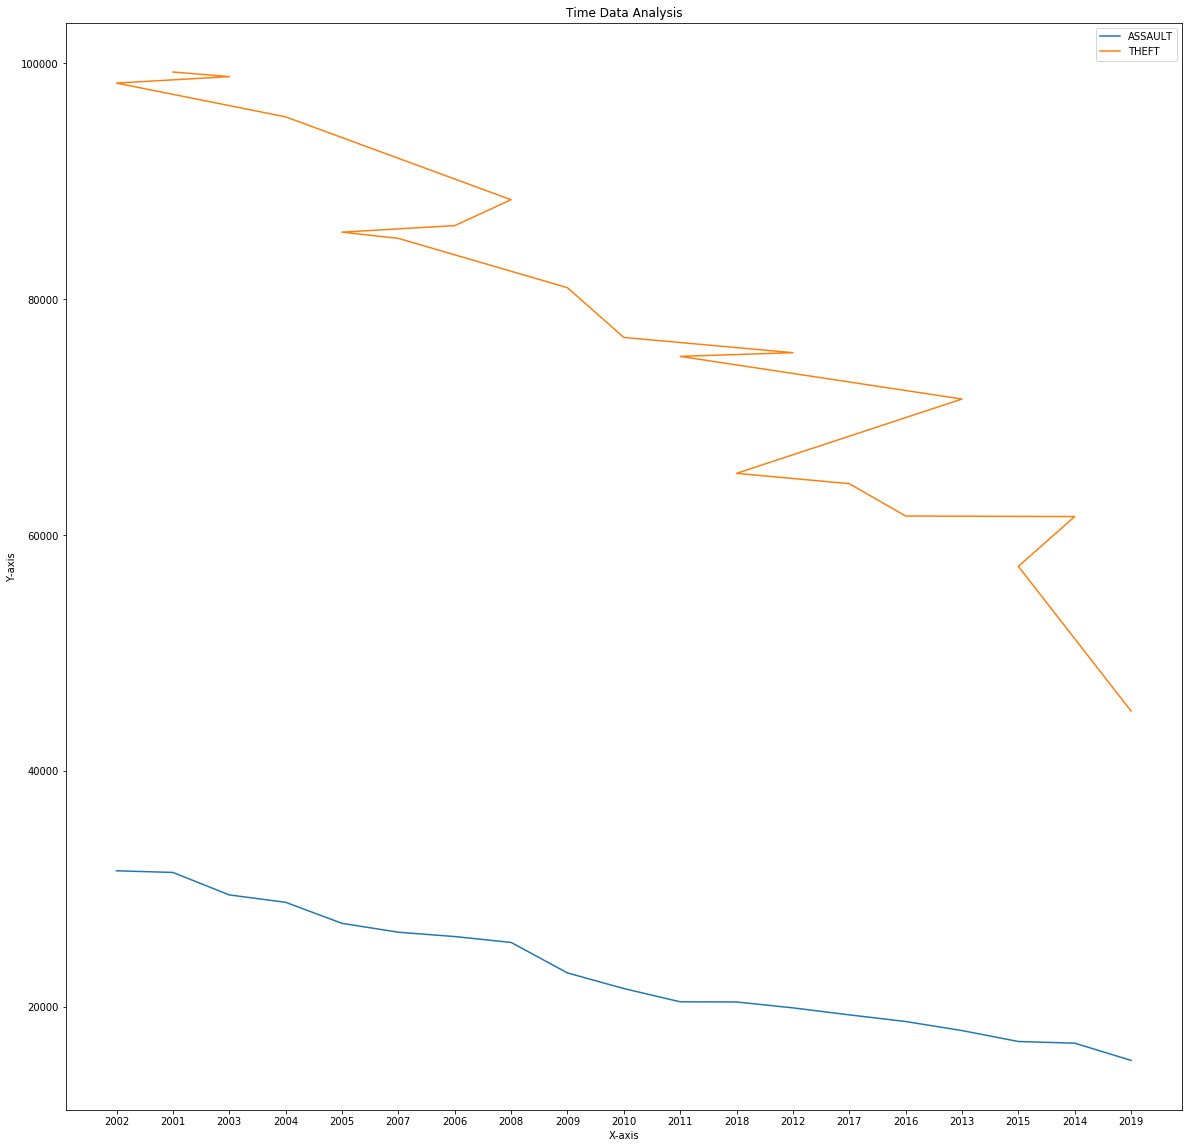

In [11]:
# Plotting graph
import matplotlib.pyplot as plt
%matplotlib inline  

plt.figure(figsize=(20,20))

#Plot a line graph
filter_list = ['THEFT','ASSAULT']
for p_type, value in time_data.items():
    years = value[0]
    counts = value[1]
    if p_type in filter_list:
        plt.plot(years, counts, label=p_type)

# Add labels and title
plt.title("Time Data Analysis")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")

plt.legend()
plt.show()